# DeepVoice3: Single-speaker text-to-speech demo

In this notebook, you can try DeepVoice3-based single-speaker text-to-speech (en) using a model trained on [LJSpeech dataset](https://keithito.com/LJ-Speech-Dataset/). The notebook is supposed to be executed on [Google colab](https://colab.research.google.com) so you don't have to setup your machines locally.

**Estimated time to complete**: 5 miniutes.

- Code: https://github.com/r9y9/deepvoice3_pytorch
- Audio samples: https://r9y9.github.io/deepvoice3_pytorch/

## Setup

### Install dependencies

In [4]:
import os
from os.path import exists, join, expanduser

# Clone
name = "deepvoice3_pytorch"
if not exists(name):
  ! git clone https://github.com/r9y9/$name

In [5]:
# Change working directory to the project dir 
os.chdir(join(expanduser("~/myprojects/deepvoice"), name))

!git checkout 7a10ac6763eda92595e257543494b6a95f64229b --quiet

# Install dependencices
!pip install -q -e '.[bin]'

thinc 6.12.0 requires msgpack<1.0.0,>=0.5.6, which is not installed.
msgpack-numpy 0.4.3.2 requires msgpack>=0.3.0, which is not installed.
fastai 1.0.20 requires torchvision-nightly, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.3 which is incompatible.
spacy 2.0.16 has requirement regex==2018.01.10, but you'll have regex 2018.8.29 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.6 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
%pylab inline
! pip install -q librosa nltk

import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

Populating the interactive namespace from numpy and matplotlib
thinc 6.12.0 requires msgpack<1.0.0,>=0.5.6, which is not installed.
msgpack-numpy 0.4.3.2 requires msgpack>=0.3.0, which is not installed.
fastai 1.0.20 requires torchvision-nightly, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.3 which is incompatible.
spacy 2.0.16 has requirement regex==2018.01.10, but you'll have regex 2018.8.29 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.6 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/opt/anaconda3/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unp

### Download a pre-trained model

In [7]:
preset = "20180505_deepvoice3_ljspeech.json"
checkpoint_path = "20180505_deepvoice3_checkpoint_step000640000.pth"

In [8]:
if not exists(preset):
  !curl -O -L "https://www.dropbox.com/s/0ck82unm0bo0rxd/20180505_deepvoice3_ljspeech.json"
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/5ucl9remrwy5oeg/20180505_deepvoice3_checkpoint_step000640000.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1795  100  1795    0     0   2049      0 --:--:-- --:--:-- --:--:--  2049
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1246    0  1246    0     0    904      0 --:--:--  0:00:01 --:--:--     0
100  151M  100  151M    0     0  20.7M      0  0:00:07  0:00:07 --:--:-- 30.2M


## Synthesis

### Setup hyper parameters

In [10]:
import hparams
import json

    
# Load parameters from preset
with open(preset) as f:
  hparams.hparams.parse_json(f.read())
  
# Inject frontend text processor
import synthesis
import train
from deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.hparams.sample_rate
hop_length = hparams.hparams.hop_size

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Define utility functions

In [11]:
def tts(model, text, p=0, speaker_id=None, fast=True, figures=True):
  from synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  if figures:
      visualize(alignment, spectrogram)
  IPython.display.display(Audio(waveform, rate=fs))
  
def visualize(alignment, spectrogram):
  label_fontsize = 16
  figure(figsize=(16,16))

  subplot(2,1,1)
  imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  xlabel("Decoder timestamp", fontsize=label_fontsize)
  ylabel("Encoder timestamp", fontsize=label_fontsize)
  colorbar()

  subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  xlabel("Time", fontsize=label_fontsize)
  ylabel("Hz", fontsize=label_fontsize)
  tight_layout()
  colorbar()

### Load the model checkpoint

In [12]:
from train import build_model
from train import restore_parts, load_checkpoint

model = build_model()
model = load_checkpoint(checkpoint_path, model, None, True)

Load checkpoint from: 20180505_deepvoice3_checkpoint_step000640000.pth


### Generate speech

In [13]:
# Try your favorite senteneces:)
texts = [
    "Scientists at the CERN laboratory say they have discovered a new particle.",
    "There's a way to measure the acute emotional intelligence that has never gone out of style.",
    "President Trump met with other leaders at the Group of 20 conference.",
    "The Senate's bill to repeal and replace the Affordable Care Act is now imperiled.",
    "Generative adversarial network or variational auto-encoder.",
    "The buses aren't the problem, they actually provide a solution.",
    "peter piper picked a peck of pickled peppers how many peppers did peter piper pick.",
    "Some have accepted this as a miracle without any physical explanation.",
]

for idx, text in enumerate(texts):
  print(idx, text)
  tts(model, text, figures=False)

0 Scientists at the CERN laboratory say they have discovered a new particle.


/opt/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  y = y_soft


1 There's a way to measure the acute emotional intelligence that has never gone out of style.


2 President Trump met with other leaders at the Group of 20 conference.


3 The Senate's bill to repeal and replace the Affordable Care Act is now imperiled.


4 Generative adversarial network or variational auto-encoder.


5 The buses aren't the problem, they actually provide a solution.


6 peter piper picked a peck of pickled peppers how many peppers did peter piper pick.


7 Some have accepted this as a miracle without any physical explanation.


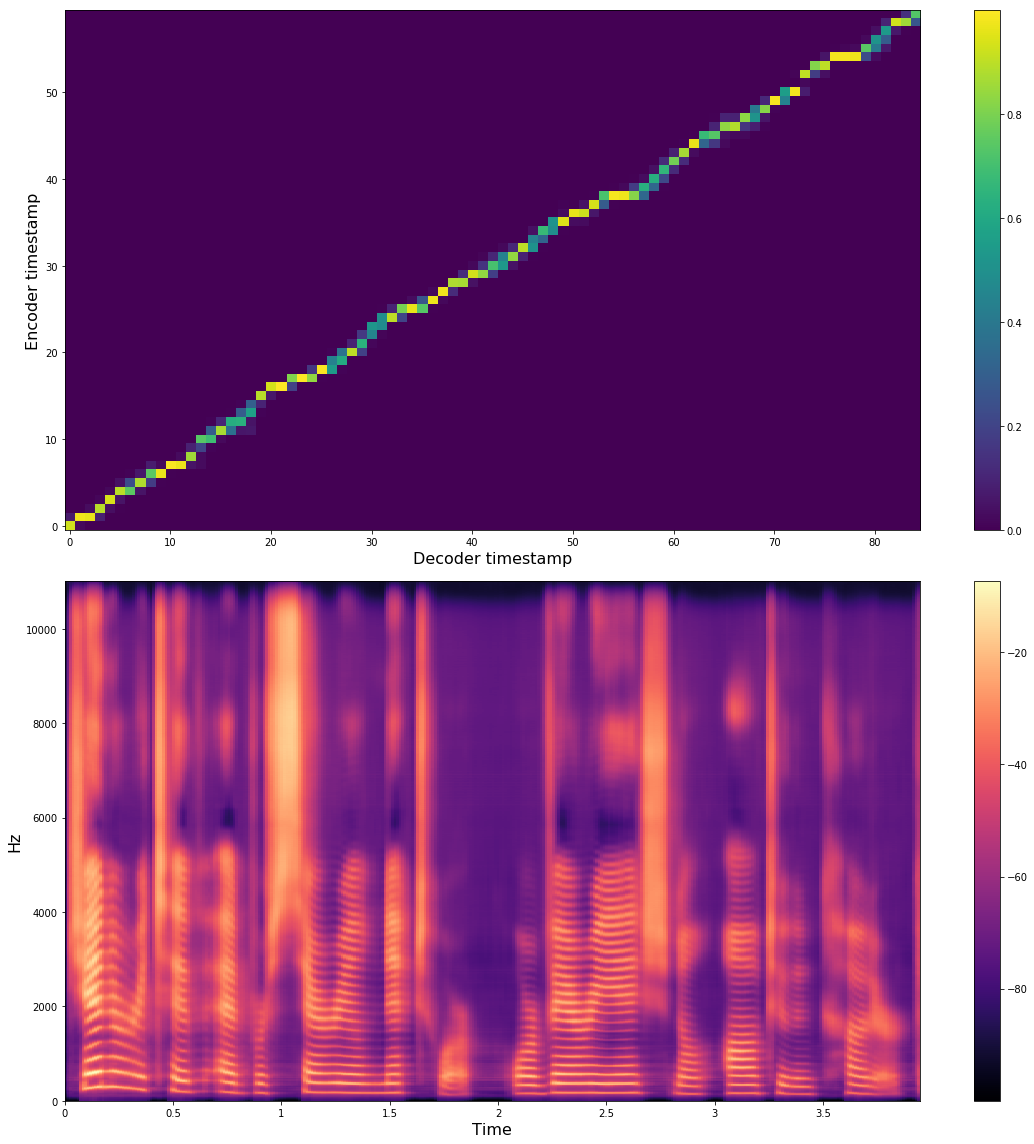

In [14]:
# With attention plot
text = "Generative adversarial network or variational auto-encoder."
tts(model, text, figures=True)

For details, please visit https://github.com/r9y9/deepvoice3_pytorch